# 3 Data integration in a single matrix and soft trimming

#### Dataset1: Healthy - Arabidopsis (Col-0)

#### Cynthia Soto
#### Fecha: 20 de Agosto 2020
#### Datatype representation: normalized values in log2 scale (genome name reference)
#### Data quantify with HTSeq (alignments done with STAR SA) 

Data quantifications produced with HTSeq are absolute counts.
First data needed to be cleaned and transformed to a log2 scale.
Now data-frames from the same reference-organims are going to be integrate in a single data matrix

Workflow:
1) Data assummed to be cleaned & in the same scale. (in this dataset is Log2)
2) Gene_name is used as key to merge the n dataframes and retrieve the Log2 column of each dataset 
3) Some basic statistics are build from the single matrix. 
4) A soft trimming based on ceros across all samples is performed. 


Pandas provides various facilities for easily combining together Series or DataFrame with various kinds of set logic for the indexes and relational algebra functionality in the case of join / merge-type operations.

In addition, pandas also provides utilities to compare two Series or DataFrame and summarize their differences.

Letś to merge DataFrames on specific keys by different join logics like left-join, inner-join, etc.

In [1]:
# Libraries required
import os 
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
try:
    # Change the current working Directory    
    os.chdir("/home/cyntsc/Proyectos/athal1_htseq-counts/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")    
s_path = str(os.getcwd())+'/*_Log2.csv'       
#print(os.listdir(os.getcwd())       

Directory changed: /home/cyntsc/Proyectos/athal1_htseq-counts


In [10]:
# Import Data (example with 2 cvs files)

df1=pd.read_csv("SRR3383640_Log2.csv", sep='\t', nrows=100, usecols=[1,3])
print(df1.shape)
## remove unnamed cols
## inplace = False means the result would be stored in a new DataFrame instead of the original one. If True otherwise. 
df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
#print(df1.columns)
df1.rename(columns={'log2_value':'SRR3383640'},inplace=True)
#print(df1.size)
print(df1.shape)
df1.head(5)

(100, 2)
(100, 2)


,Genes,SRR3383640
0,AT1G01010,6.523562
1,AT1G01020,6.768184
2,AT1G01030,3.807355
3,AT1G01040,10.005625
4,AT1G01050,9.733015


In [4]:
## Import Data 
df2=pd.read_csv("SRR3383641_Log2.csv", sep='\t', nrows=100, usecols=[1,3])
## Removes unnamed cols
df2.drop(df2.columns[df2.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
df2.rename(columns={'log2_value':'SRR3383641'},inplace=True)
#print(df2.size)
print(df2.shape)
df2.head(5)

(100, 2)


,Genes,SRR3383641
0,AT1G01010,7.592457
1,AT1G01020,8.066089
2,AT1G01030,4.523562
3,AT1G01040,11.165535
4,AT1G01050,10.854868


Use numpy.where(condition, x, y) with condition as a boolean expression comparing two columns. For each row of the two columns, the corresponding element of the resulting NumPy array is x if condition is True, and y otherwise.

In [5]:
## Look if different gene_names in the individual matrix
comparison_column = np.where(df1["Genes"] == df2["Genes"], True, False)
print (comparison_column)

## If True all gene_names are equal, otherwise result is False

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [6]:
## Look for 'False' bool in the comparison, if found means something is different. A false means all are true (equal)
False in comparison_column

False

In [9]:
df1=df1.merge(df2,on=['Genes'],how='left')
df1

(100, 5)

## Integration to all cvs data files (samples) in one matrix 

In [280]:
## CREATE A SINGLE MATRIX

all_files = glob.glob(s_path)
## To load the main df
flag_b=True

for file in all_files:
    
    ## GET FILE NAME TO STORE STATISTICS
    f_name = file.split("_")
    x= f_name[1]
    f_name1=x.split("/")
    x1= f_name1[1]
    #print(x1)
    
    if flag_b:    ## load main df once
        #print(file)
        ## Main df is df1
        df1=pd.read_csv(file, sep='\t', usecols=[1,3])    ## nrows=100, 
        ## remove unnamed cols
        df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
        df1.rename(columns={'log2_value':x1},inplace=True)
        #print(df1) 
        flag_b=False
    else:
        #print(file)
        df2= pd.read_csv(file, sep='\t', usecols=[1,3])     ## nrows=100, 
        ## remove unnamed cols
        df2.drop(df2.columns[df2.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)      
        ## compare matrix gene_names before concatenated
        comparison_column = np.where(df1["Genes"] == df2["Genes"], True, False)
        if (False in comparison_column):
            print("Gene_names are not the same. Matrix "+file+" will not be concatenated.")
        else:
            ## merge matrix based in column name "Genes"
            df2.rename(columns={'log2_value':x1},inplace=True)
            df1=df1.merge(df2,on=['Genes'],how='left')
        
    ## Send the concatenated matrix to all_Log2.csv for a statistical further analysis
    #df.to_csv('all_samples_log2.csv', sep='\t', index=True)

In [281]:
df1

,Genes,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144
0,AT1G01010,6.523562,7.055282,6.845490,6.266787,7.592457,5.857981,6.066089,7.507795
1,AT1G01020,6.768184,7.189825,7.813781,7.459432,8.066089,6.882643,6.539159,7.357552
2,AT1G01030,3.807355,3.321928,5.169925,4.392317,4.523562,3.807355,4.087463,4.700440
3,AT1G01040,10.005625,9.992938,11.214926,11.311748,11.165535,10.371777,9.319672,11.283667
4,AT1G01050,9.733015,9.419960,11.379920,10.581201,10.854868,10.250298,8.668885,10.817783
...,...,...,...,...,...,...,...,...,...
27650,ATMG01350,1.000000,1.584963,0.000000,3.000000,1.584963,1.000000,0.000000,3.169925
27651,ATMG01360,4.392317,4.807355,5.700440,6.554589,6.247928,4.807355,4.523562,6.392317
27652,ATMG01370,4.643856,5.129283,5.321928,5.832890,6.228819,4.169925,4.321928,4.321928
27653,ATMG01400,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


## Some basic statistic to the integrated data matrix

1) Gene expression cvs files are integreted in one matrix
2) Gene ID with cero counts in expression across all the samples are got it
3) Gene IDs identifiers are dropped from the the sample df(s) to compose the dataset2. 

In [282]:
#Check number of zeros by sample
df1.isin([0]).sum()

Genes            0
SRR3383640    7396
SRR3383821    7360
SRR3383782    6888
SRR6283145    7688
SRR3383641    7039
SRR3383783    7627
SRR3383822    7702
SRR6283144    7700
dtype: int64

In [285]:
s_zeros=(df1 == 0).astype(int).sum(axis=1)
#print(s_zeros)
#type(s_zeros)    ### build a serie-pandas
## Desglozando la formula
#(df1 == 0)
#(df1 == 0).astype(int)
#(df1 == 0).sum(axis=1)

## Added a column to df1 with the counter of zeros
df1['zero-counter'] = s_zeros
df1
## Send the integrated matrix to all_log2_counter_cero.csv 
df1.to_csv('all_log2_counter_cero.csv', sep='\t', index=True)

In [303]:
## Filter for looking rows with x number of ceros
is_zero = (df1['zero-counter']>=8)     
df1_8 = df1[is_zero]
print(df1_8.shape)
print(df1_8.head(7))
## Send the integrated matrix to all_log2_counter_cero.csv 
#df1_8.to_csv('all_log2_8_ceros.csv', sep='\t', index=True)

(5228, 10)
         Genes  SRR3383640  SRR3383821  SRR3383782  SRR6283145  SRR3383641  \
27   AT1G01280         0.0         0.0         0.0         0.0         0.0   
30   AT1G01305         0.0         0.0         0.0         0.0         0.0   
33   AT1G01335         0.0         0.0         0.0         0.0         0.0   
41   AT1G01400         0.0         0.0         0.0         0.0         0.0   
42   AT1G01410         0.0         0.0         0.0         0.0         0.0   
48   AT1G01460         0.0         0.0         0.0         0.0         0.0   
100  AT1G01980         0.0         0.0         0.0         0.0         0.0   

     SRR3383783  SRR3383822  SRR6283144  zero-counter  
27          0.0         0.0         0.0             8  
30          0.0         0.0         0.0             8  
33          0.0         0.0         0.0             8  
41          0.0         0.0         0.0             8  
42          0.0         0.0         0.0             8  
48          0.0         0.0 

In [304]:
df1_8.isin([0]).sum()

Genes              0
SRR3383640      5228
SRR3383821      5228
SRR3383782      5228
SRR6283145      5228
SRR3383641      5228
SRR3383783      5228
SRR3383822      5228
SRR6283144      5228
zero-counter       0
dtype: int64

## Making a soft trimming of data

### First, we drop identified genes with ceros across all the samples
1) All data are cleaned and normalized to log2
2) First soft trimming: remove gene-IDs counting cero across all samples

x = Si - 1 

Donde:
Si = es el numero de cero conteos traves del todas las muestras para un gen determinado
Ejm: si el tamaño del conjunto es de 8 muestras, entonces 8 es el número máximo de ceros que puede tener un gen, asumiendo que no hubo expresión de ese gen para ninguna de las muestra. 
x =   es Si  -1


In [291]:
## Save the gene IDs with ceros in a file 
genes_cero_ToList = list(df1_8['Genes']

with open("all_genesIDs_cero", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))

In [293]:
genes_cero_ToList
#df1_8.head()

['AT1G01280',
 'AT1G01305',
 'AT1G01335',
 'AT1G01400',
 'AT1G01410',
 'AT1G01460',
 'AT1G01980',
 'AT1G02067',
 'AT1G02210',
 'AT1G02320',
 'AT1G02510',
 'AT1G02540',
 'AT1G02550',
 'AT1G02575',
 'AT1G02590',
 'AT1G02710',
 'AT1G02790',
 'AT1G02813',
 'AT1G02830',
 'AT1G02965',
 'AT1G02980',
 'AT1G03103',
 'AT1G03106',
 'AT1G03325',
 'AT1G03395',
 'AT1G03490',
 'AT1G03700',
 'AT1G03720',
 'AT1G03810',
 'AT1G03880',
 'AT1G03890',
 'AT1G03982',
 'AT1G04150',
 'AT1G04450',
 'AT1G04455',
 'AT1G04470',
 'AT1G04560',
 'AT1G04610',
 'AT1G04660',
 'AT1G04670',
 'AT1G04890',
 'AT1G04895',
 'AT1G05005',
 'AT1G05085',
 'AT1G05240',
 'AT1G05250',
 'AT1G05280',
 'AT1G05290',
 'AT1G05291',
 'AT1G05510',
 'AT1G05580',
 'AT1G05615',
 'AT1G05650',
 'AT1G05660',
 'AT1G05740',
 'AT1G05920',
 'AT1G05930',
 'AT1G06080',
 'AT1G06100',
 'AT1G06120',
 'AT1G06137',
 'AT1G06225',
 'AT1G06280',
 'AT1G06310',
 'AT1G06320',
 'AT1G06330',
 'AT1G06340',
 'AT1G06350',
 'AT1G06923',
 'AT1G06990',
 'AT1G07175',
 'AT1G

In [350]:
## Get the index number of the gene rows to delete it from df
lst_genes_to_drop=(df1_8.index)
print(lst_genes_to_drop)

Int64Index([   27,    30,    33,    41,    42,    48,   100,   110,   126,
              137,
            ...
            27630, 27631, 27633, 27634, 27636, 27638, 27642, 27645, 27646,
            27647],
           dtype='int64', length=5228)


In [335]:
df1.head(35)     ## see idx=27,30 y 33 full of zeros

,Genes,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,zero-counter
0,AT1G01010,6.523562,7.055282,6.845490,6.266787,7.592457,5.857981,6.066089,7.507795,0
1,AT1G01020,6.768184,7.189825,7.813781,7.459432,8.066089,6.882643,6.539159,7.357552,0
2,AT1G01030,3.807355,3.321928,5.169925,4.392317,4.523562,3.807355,4.087463,4.700440,0
3,AT1G01040,10.005625,9.992938,11.214926,11.311748,11.165535,10.371777,9.319672,11.283667,0
4,AT1G01050,9.733015,9.419960,11.379920,10.581201,10.854868,10.250298,8.668885,10.817783,0
5,AT1G01060,8.174926,8.596190,14.989173,3.584963,9.707359,14.150461,7.781360,2.321928,0
6,AT1G01070,5.426265,7.761551,8.285402,5.321928,6.339850,7.434628,5.954196,6.741467,0
7,AT1G01080,9.930737,8.951285,11.053247,10.323055,10.912889,9.939579,8.748193,10.144658,0
8,AT1G01090,10.324181,10.422065,11.934059,12.310613,11.452241,10.813781,9.911392,12.558660,0
9,AT1G01100,8.918863,9.184875,10.366322,10.510764,10.051209,8.977280,8.643856,10.088788,0


In [367]:
print(df1.shape)
for i in lst_genes_to_drop: 
    #print(i) 
    try:
        df1 = df1.drop([i])
    except:
        pass # doing nothing on exception, not processed because it is already dropped"

(27652, 10)
27
30
33
41
42
48
100
110
126
137
158
161
162
165
167
179
186
189
192
206
208
222
223
247
256
265
283
285
294
301
302
313
330
360
361
362
372
377
385
386
407
408
422
433
450
451
454
455
456
477
486
490
494
495
504
527
528
543
545
547
550
562
568
570
571
572
573
574
629
636
656
658
673
688
697
698
711
712
721
726
732
758
762
767
768
769
797
820
823
825
834
852
853
857
869
881
893
894
914
923
929
941
969
987
994
1007
1018
1032
1043
1046
1047
1048
1052
1053
1067
1068
1078
1082
1089
1094
1102
1127
1128
1133
1134
1142
1144
1145
1146
1147
1148
1155
1165
1183
1189
1190
1199
1206
1210
1211
1212
1237
1251
1256
1261
1262
1269
1277
1286
1295
1297
1310
1312
1328
1329
1339
1348
1349
1350
1351
1359
1365
1366
1372
1375
1379
1380
1385
1393
1409
1413
1426
1436
1451
1458
1463
1479
1489
1508
1509
1510
1552
1555
1563
1575
1576
1577
1580
1581
1584
1592
1594
1604
1624
1641
1657
1692
1708
1713
1714
1715
1718
1719
1720
1737
1755
1779
1798
1802
1805
1815
1823
1824
1825
1826
1834
1835
1836
1854
1875

8396
8397
8402
8403
8405
8411
8412
8438
8442
8444
8446
8451
8452
8468
8469
8477
8478
8481
8499
8504
8507
8508
8516
8526
8527
8530
8531
8532
8533
8539
8555
8565
8566
8577
8580
8581
8582
8590
8591
8606
8607
8629
8630
8632
8645
8650
8652
8653
8655
8656
8657
8659
8660
8665
8676
8686
8687
8688
8689
8690
8697
8702
8703
8705
8710
8717
8720
8732
8739
8758
8765
8766
8781
8782
8783
8784
8793
8794
8806
8807
8809
8815
8816
8817
8818
8819
8833
8837
8838
8842
8848
8849
8854
8855
8856
8867
8871
8874
8880
8881
8885
8886
8894
8906
8912
8920
8929
8934
8935
8939
8951
8952
8954
8959
8962
8965
8968
8969
8975
8979
8983
9001
9002
9006
9007
9010
9014
9016
9026
9028
9031
9032
9035
9036
9037
9063
9071
9090
9092
9100
9101
9118
9133
9138
9139
9146
9150
9163
9174
9187
9189
9191
9197
9198
9212
9220
9231
9232
9234
9241
9242
9247
9248
9251
9263
9265
9267
9268
9269
9270
9278
9281
9286
9302
9309
9310
9311
9318
9327
9332
9338
9345
9347
9353
9363
9375
9377
9379
9383
9389
9400
9401
9414
9417
9430
9436
9454
9461
9473
9474


17037
17040
17047
17048
17052
17061
17078
17079
17086
17088
17111
17115
17116
17128
17129
17133
17144
17145
17158
17192
17195
17201
17202
17204
17207
17208
17226
17230
17247
17248
17259
17260
17274
17278
17290
17291
17303
17306
17307
17308
17322
17324
17328
17329
17330
17342
17345
17354
17355
17357
17361
17362
17364
17365
17366
17368
17371
17377
17379
17380
17381
17382
17389
17396
17397
17408
17411
17417
17419
17422
17427
17433
17450
17454
17458
17459
17460
17471
17474
17475
17480
17486
17489
17490
17491
17492
17493
17494
17497
17498
17511
17514
17517
17518
17520
17521
17522
17524
17525
17526
17527
17530
17534
17535
17536
17538
17541
17542
17543
17548
17550
17551
17552
17553
17554
17555
17556
17559
17560
17561
17568
17569
17570
17572
17573
17578
17583
17584
17585
17586
17594
17595
17596
17598
17600
17601
17602
17608
17612
17616
17618
17623
17624
17625
17626
17629
17631
17632
17633
17637
17639
17641
17642
17643
17648
17649
17664
17667
17669
17670
17671
17672
17676
17680
17681
17682
1768

24451
24455
24458
24466
24473
24476
24477
24489
24503
24507
24510
24513
24517
24524
24535
24536
24543
24553
24561
24573
24581
24582
24594
24596
24597
24598
24599
24603
24604
24605
24607
24617
24618
24626
24632
24641
24663
24675
24681
24682
24683
24688
24697
24704
24706
24714
24715
24720
24722
24723
24724
24728
24729
24745
24759
24761
24762
24767
24768
24774
24777
24781
24782
24783
24786
24788
24796
24798
24802
24803
24809
24811
24815
24817
24818
24820
24822
24834
24835
24836
24837
24839
24840
24844
24846
24854
24855
24863
24914
24919
24920
24923
24925
24926
24930
24932
24940
24943
24946
24970
24971
24973
24978
24979
24985
24986
24992
24993
24994
25001
25003
25004
25005
25023
25031
25034
25039
25071
25072
25079
25084
25102
25103
25104
25105
25106
25108
25115
25117
25120
25124
25139
25150
25151
25152
25153
25175
25182
25201
25203
25204
25212
25213
25214
25216
25217
25221
25222
25223
25225
25226
25227
25228
25236
25237
25245
25260
25261
25265
25276
25328
25331
25332
25333
25342
25345
2534

In [369]:
print(df1.shape)
df1.head()

(22427, 10)


,Genes,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,zero-counter
0,AT1G01010,6.523562,7.055282,6.845490,6.266787,7.592457,5.857981,6.066089,7.507795,0
1,AT1G01020,6.768184,7.189825,7.813781,7.459432,8.066089,6.882643,6.539159,7.357552,0
2,AT1G01030,3.807355,3.321928,5.169925,4.392317,4.523562,3.807355,4.087463,4.700440,0
3,AT1G01040,10.005625,9.992938,11.214926,11.311748,11.165535,10.371777,9.319672,11.283667,0
4,AT1G01050,9.733015,9.419960,11.379920,10.581201,10.854868,10.250298,8.668885,10.817783,0


In [370]:
df1.to_csv('all_log2_dropped8ceros.csv', sep='\t', index=True)

## Now explore the new distributions without ceros across all samples
### Plot all the sample in one plot (histogram and KDE)

In [100]:
# load file to plot and format df to be plotted 

#print(os.listdir(os.getcwd()))
df_nozeros=pd.read_csv("all_log2_dropped8ceros.csv", sep='\t')
## remove unnamed cols
df_nozeros.drop(df_nozeros.columns[df_nozeros.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
# dropping not-useful columns 
df_nozeros.drop(["Genes", "zero-counter"], axis = 1, inplace = True) 
print(df_nozeros.head())

## Get sample list names
sample_lst=df_nozeros.columns
print(sample_lst)

   SRR3383640  SRR3383821  SRR3383782  SRR6283145  SRR3383641  SRR3383783  \
0    6.523562    7.055282    6.845490    6.266787    7.592457    5.857981   
1    6.768184    7.189825    7.813781    7.459432    8.066089    6.882643   
2    3.807355    3.321928    5.169925    4.392317    4.523562    3.807355   
3   10.005625    9.992938   11.214926   11.311748   11.165535   10.371777   
4    9.733015    9.419960   11.379920   10.581201   10.854868   10.250298   

   SRR3383822  SRR6283144  
0    6.066089    7.507795  
1    6.539159    7.357552  
2    4.087463    4.700440  
3    9.319672   11.283667  
4    8.668885   10.817783  
Index(['SRR3383640', 'SRR3383821', 'SRR3383782', 'SRR6283145', 'SRR3383641',
       'SRR3383783', 'SRR3383822', 'SRR6283144'],
      dtype='object')


Plot both the histogram and densities in the same plot with the seaborn package (imported as sns) which allows you to do that via the distplot(). 
Since seaborn is built on top of matplotlib, you can use the sns and plt one after the other.

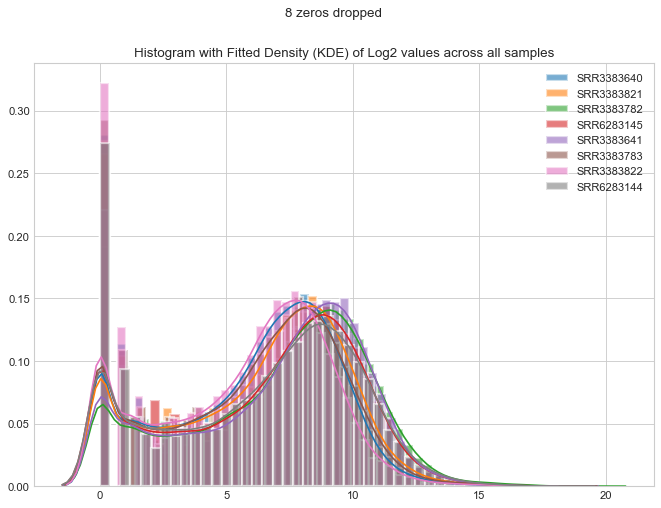

In [101]:
# Values are log2 normalized 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    #print(file)
    sample_data = df_nozeros[file].tolist()
    #print(sample_data)
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Histogram with Fitted Density (KDE) of Log2 values across all samples');
plt.suptitle("8 zeros dropped")
plt.legend();
plt.savefig("../athal1_stats/all_fitted density_drop8zeros.png");

### Addtional trimming of IDs  (drop 7 zeros across samples)

In [93]:
## Filter for looking rows with x number of ceros (second parse)
## Take the lastet dropped file to save cpu performance 

df_nozeros=pd.read_csv("all_log2_dropped8ceros.csv", sep='\t')
is_zero7 = (df_nozeros['zero-counter']>=7)     
#print(is_zero7)
df1_7 = df_nozeros[is_zero7]
print(" Match records: "+ str(df1_7.shape))
print(df1_7)

## Send the integrated matrix 
df1_7.to_csv('all_log2_7_ceros.csv', sep='\t', index=True)

 Match records: (950, 11)
       Unnamed: 0      Genes  SRR3383640  SRR3383821  SRR3383782  SRR6283145  \
14             14  AT1G01150    0.000000         0.0         1.0    0.000000   
102           109  AT1G02065    0.000000         0.0         0.0    2.000000   
120           129  AT1G02250    2.807355         0.0         0.0    0.000000   
146           156  AT1G02490    1.000000         0.0         0.0    0.000000   
151           164  AT1G02570    0.000000         0.0         0.0    0.000000   
...           ...        ...         ...         ...         ...         ...   
22409       27627  ATMG01110    0.000000         0.0         0.0    1.000000   
22415       27639  ATMG01240    0.000000         0.0         0.0    0.000000   
22416       27640  ATMG01250    0.000000         0.0         0.0    0.000000   
22417       27641  ATMG01260    0.000000         0.0         0.0    2.000000   
22418       27643  ATMG01275    0.000000         0.0         0.0    1.584963   

       SRR338

In [94]:
df1_7.isin([0]).sum()

Unnamed: 0        0
Genes             0
SRR3383640      846
SRR3383821      843
SRR3383782      778
SRR6283145      806
SRR3383641      793
SRR3383783      872
SRR3383822      871
SRR6283144      841
zero-counter      0
dtype: int64

In [95]:
## Save the gene IDs with cero in a file 
genes_cero_ToList = list(df1_7['Genes'])

with open("all_genesIDs_7cero", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))

In [96]:
## Get the index number of the gene rows to delete it from df
lst_genes_to_drop=(df1_7.index)

print("Current dimensions: ",str(df_nozeros.shape))
## Drop the Gene-IDs provided
for i in lst_genes_to_drop: 
    #print(i) 
    try:
        df_nozeros = df_nozeros.drop([i])
    except:
        pass # doing nothing on exception, not processed because it is already dropped"

# Save the result to a new file of Si-1 
df_nozeros.to_csv('all_log2_dropped7ceros.csv', sep='\t', index=True)
print("New dimensions: ",str(df_nozeros.shape))

Current dimensions:  (22427, 11)
New dimensions:  (21477, 11)


### Plot again to see the new distribution

In [97]:
## sample names
sample_lst

Index(['SRR3383640', 'SRR3383821', 'SRR3383782', 'SRR6283145', 'SRR3383641',
       'SRR3383783', 'SRR3383822', 'SRR6283144'],
      dtype='object')

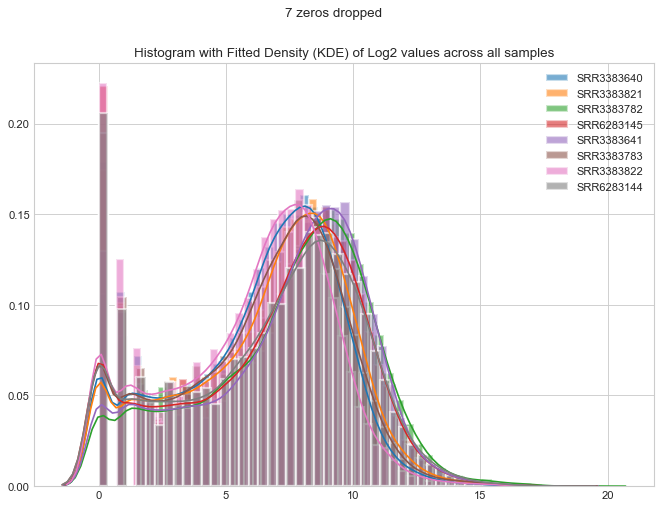

In [99]:
# Values are log2 normalized 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    #print(file)
    sample_data = df_nozeros[file].tolist()
    #print(sample_data)
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Histogram with Fitted Density (KDE) of Log2 values across all samples');
plt.suptitle("7 zeros dropped")
plt.legend();
plt.savefig("../athal1_stats/all_fitted density_drop7zeros.png");

### Addtional trimming of IDs  (drop 6 zeros across samples)

In [102]:
## Filter for looking rows with x number of ceros (second parse)
## Take the latest dropped file to save cpu performance 

df_nozeros=pd.read_csv("all_log2_dropped7ceros.csv", sep='\t')
is_zero6 = (df_nozeros['zero-counter']>=6)     
#print(is_zero6)
df1_6 = df_nozeros[is_zero6]
print(" Match records: "+ str(df1_6.shape))
#print(df1_6)
## Send the integrated matrix 
df1_6.to_csv('all_log2_6_ceros.csv', sep='\t', index=True)

 Match records: (610, 12)


In [103]:
## Save the gene IDs with cero in a file 
genes_cero_ToList = list(df1_6['Genes'])

with open("all_genesIDs_6cero", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))
    
## Get the index number of the gene rows to delete it from df
lst_genes_to_drop=(df1_6.index)

print("Current dimensions: ",str(df_nozeros.shape))
## Drop the Gene-IDs provided
for i in lst_genes_to_drop: 
    #print(i) 
    try:
        df_nozeros = df_nozeros.drop([i])
    except:
        pass # doing nothing on exception, not processed because it is already dropped"

# Save the result to a new file of Si-1 
df_nozeros.to_csv('all_log2_dropped6ceros.csv', sep='\t', index=True)
print("New dimensions: ",str(df_nozeros.shape))

Current dimensions:  (21477, 12)
New dimensions:  (20867, 12)


### Plot again to see the new distribution

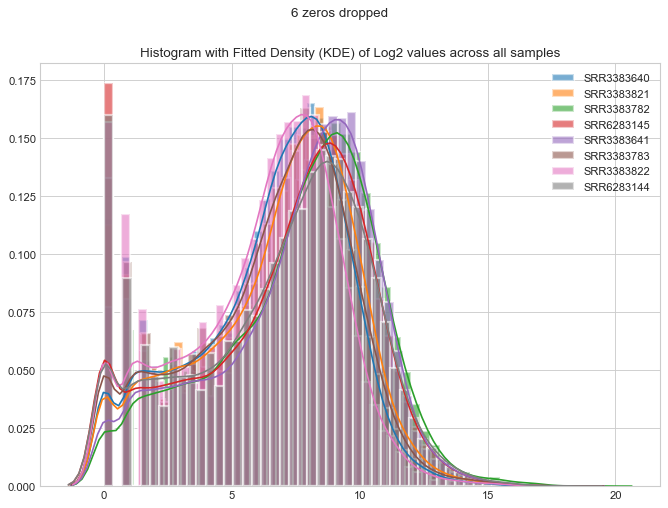

In [104]:
#Values are log2 normalized 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    #print(file)
    sample_data = df_nozeros[file].tolist()
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Histogram with Fitted Density (KDE) of Log2 values across all samples');
plt.suptitle("6 zeros dropped")
plt.legend();
plt.savefig("../athal1_stats/all_fitted density_drop6zeros.png");

In [105]:
## Another round dropping 5
df_nozeros=pd.read_csv("all_log2_dropped6ceros.csv", sep='\t')
is_zero5 = (df_nozeros['zero-counter']>=5)     
#print(is_zero5)
df1_5 = df_nozeros[is_zero5]
print("Match records: "+ str(df1_5.shape))
## Send to file 
df1_5.to_csv('all_log2_5_ceros.csv', sep='\t', index=True)

## Save the gene IDs with cero in a file 
genes_cero_ToList = list(df1_5['Genes'])

## write the GeneIDs to a file 
with open("all_genesIDs_5cero", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))
    
## Get the index number of the gene rows to delete it from df
lst_genes_to_drop=(df1_5.index)

print("Current dimensions: ",str(df_nozeros.shape))
## Drop the Gene-IDs provided
for i in lst_genes_to_drop: 
    #print(i) 
    try:
        df_nozeros = df_nozeros.drop([i])
    except:
        pass # doing nothing on exception, not processed because it is already dropped"

# Save the result to a new file of Si-1 
df_nozeros.to_csv('all_log2_dropped5ceros.csv', sep='\t', index=True)
print("New dimensions: ",str(df_nozeros.shape))

 Match records: (472, 13)
Current dimensions:  (20867, 13)
New dimensions:  (20395, 13)


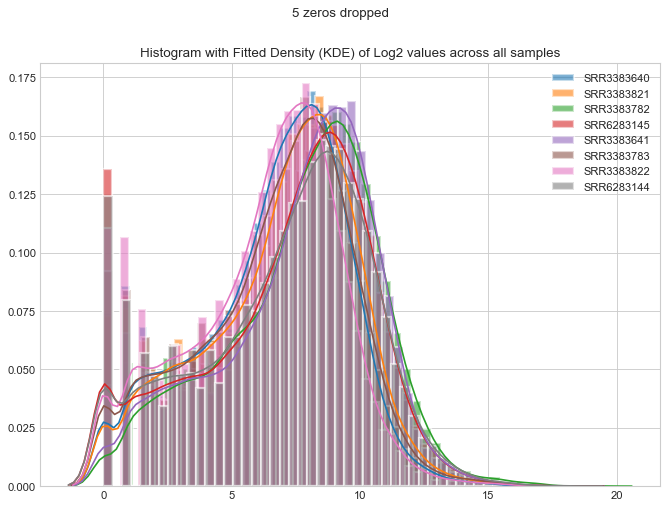

In [106]:
## Plot again 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    #print(file)
    sample_data = df_nozeros[file].tolist()
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Histogram with Fitted Density (KDE) of Log2 values across all samples');
plt.suptitle("5 zeros dropped")
plt.legend();
plt.savefig("../athal1_stats/all_fitted density_drop5zeros.png");

In [107]:
## Another round dropping 4
df_nozeros=pd.read_csv("all_log2_dropped5ceros.csv", sep='\t')
is_zero4 = (df_nozeros['zero-counter']>=4)     
#print(is_zero4)
df1_4 = df_nozeros[is_zero4]
print("Match records: "+ str(df1_4.shape))
## Send to file 
df1_4.to_csv('all_log2_4_ceros.csv', sep='\t', index=True)

## Save the gene IDs with cero in a file 
genes_cero_ToList = list(df1_4['Genes'])

## write the GeneIDs to a file 
with open("all_genesIDs_4cero", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))
    
## Get the index number of the gene rows to delete it from df
lst_genes_to_drop=(df1_4.index)

print("Current dimensions: ",str(df_nozeros.shape))
## Drop the Gene-IDs provided
for i in lst_genes_to_drop: 
    #print(i) 
    try:
        df_nozeros = df_nozeros.drop([i])
    except:
        pass # doing nothing on exception, not processed because it is already dropped"

# Save the result to a new file of Si-1 
df_nozeros.to_csv('all_log2_dropped4ceros.csv', sep='\t', index=True)
print("New dimensions: ",str(df_nozeros.shape))

Match records: (389, 14)
Current dimensions:  (20395, 14)
New dimensions:  (20006, 14)


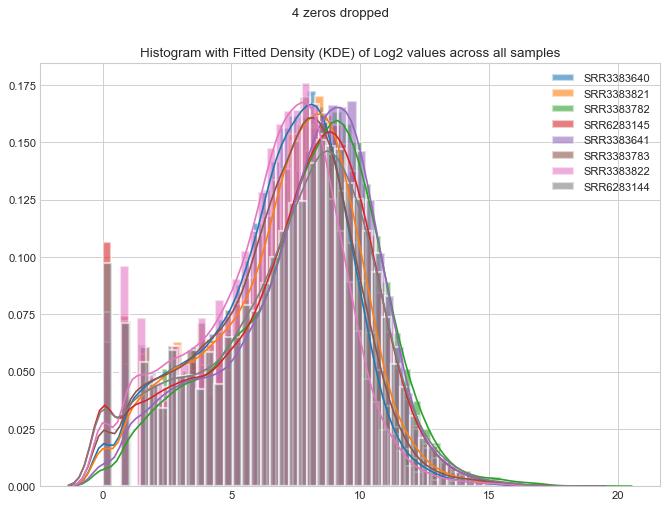

In [108]:
## Plot again 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    #print(file)
    sample_data = df_nozeros[file].tolist()
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Histogram with Fitted Density (KDE) of Log2 values across all samples');
plt.suptitle("4 zeros dropped")
plt.legend();
plt.savefig("../athal1_stats/all_fitted density_drop4zeros.png");

In [109]:
## Another round dropping 3
df_nozeros=pd.read_csv("all_log2_dropped4ceros.csv", sep='\t')
is_zero3 = (df_nozeros['zero-counter']>=3)     
#print(is_zero3)
df1_3 = df_nozeros[is_zero3]
print("Match records: "+ str(df1_3.shape))
## Send to file 
df1_3.to_csv('all_log2_3_ceros.csv', sep='\t', index=True)

## Save the gene IDs with cero in a file 
genes_cero_ToList = list(df1_3['Genes'])

## write the GeneIDs to a file 
with open("all_genesIDs_3cero", "w") as outfile:
    outfile.write("\n".join(str(item) for item in genes_cero_ToList))
    
## Get the index number of the gene rows to delete it from df
lst_genes_to_drop=(df1_3.index)

print("Current dimensions: ",str(df_nozeros.shape))
## Drop the Gene-IDs provided
for i in lst_genes_to_drop: 
    #print(i) 
    try:
        df_nozeros = df_nozeros.drop([i])
    except:
        pass # doing nothing on exception, not processed because it is already dropped"

# Save the result to a new file of Si-1 
df_nozeros.to_csv('all_log2_dropped3ceros.csv', sep='\t', index=True)
print("New dimensions: ",str(df_nozeros.shape))

Match records: (447, 15)
Current dimensions:  (20006, 15)
New dimensions:  (19559, 15)


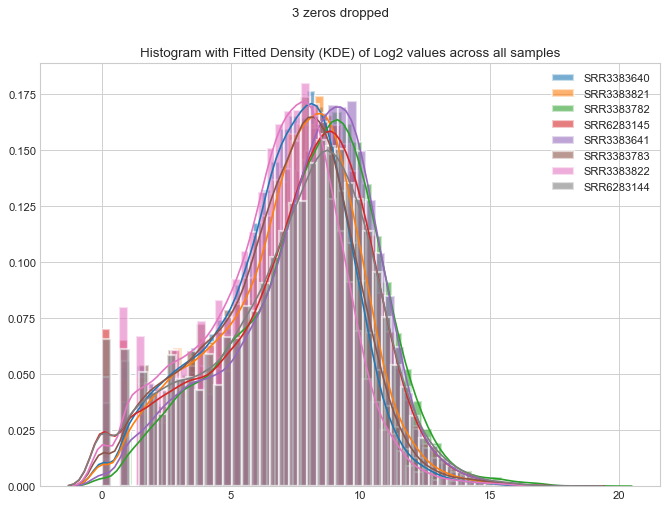

In [110]:
## Plot again 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    #print(file)
    sample_data = df_nozeros[file].tolist()
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Histogram with Fitted Density (KDE) of Log2 values across all samples');
plt.suptitle("3 zeros dropped")
plt.legend();
plt.savefig("../athal1_stats/all_fitted density_drop3zeros.png");